<h1>Interactive widget to explore DN model</h1>

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, Layout, VBox, HBox, Checkbox

There are different parameters that play a role in the DN model. The DN pRF profile is built up from 2 Gaussians in the following way:
$$ P(x) = {aG1(x) + b \over cG2(x) + d} - {b \over d} $$

Where G1 indicates the activation Gaussian pRF, and G2 the normalization Gaussian pRF (both can have different sizes). This widget allows for modulation of all of the parameters. It assumes that the pRF center for both Gaussians are the same, centered around 0. All units are measured in angular degrees of visual field.

interactive(children=(FloatSlider(value=30.0, description='a:', layout=Layout(margin='0 auto', width='30%'), m…

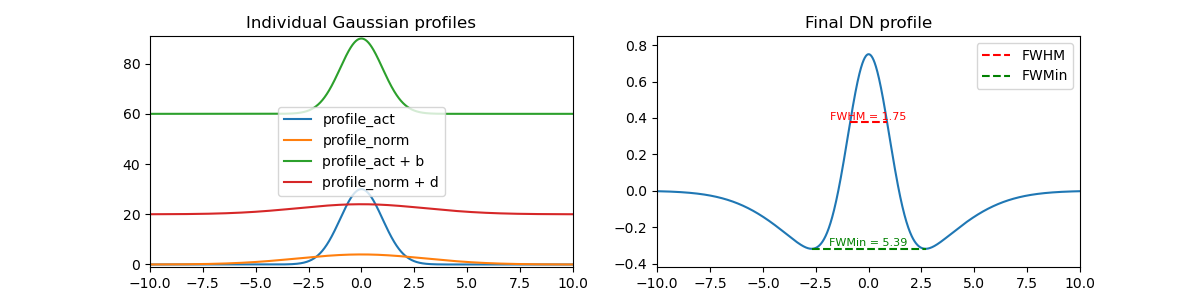

In [4]:
# Create initial figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

# Initialize plot lines
line_left, = axes[0].plot([], [], label='profile_act')
line_right, = axes[0].plot([], [], label='profile_norm')
line_act_b, = axes[0].plot([], [], label='profile_act + b')
line_norm_d, = axes[0].plot([], [], label='profile_norm + d')
line_profile, = axes[1].plot([], [])
line_fwhm, = axes[1].plot([], [], color='red', linestyle='--', label='FWHM')
line_fwmin, = axes[1].plot([], [], color='green', linestyle='--', label='FWMin')
fwhm_text = axes[1].text(0, 0, '', ha='center', va='center', fontsize=8, color='red')
fwmin_text = axes[1].text(0, 0, '', ha='center', va='center', fontsize=8, color='green')

axes[0].legend()
axes[1].legend()
axes[0].set_title('Individual Gaussian profiles')
axes[1].set_title('Final DN profile')

# Function to update plots
def update_plot(a, b, act_prf_size, c, d, norm_prf_size, normalize):
    x = np.linspace(-10, 10, 2000)
    
    # calculate the activation pRF profile (and the volume underneath pRF)
    profile_act = a * np.exp(-0.5*(x**2) / (act_prf_size**2))
    volume_act = np.sqrt(2*np.pi*(act_prf_size**2)) # NOT USED NOW, CAN BE USED LATER!!

    # calculate the normalization pRF profule (and the volume underneath pRF)
    profile_norm = c * np.exp(-0.5*(x**2) / (norm_prf_size**2))
    volume_norm = np.sqrt(2*np.pi*(norm_prf_size**2)) # NOT USED NOW, CAN BE USED LATER!!

    # calculate full profile based on constants, profile act, and profile norm
    profile = (profile_act + b)/(profile_norm + d) - (b/d)

    # Normalize profile if checkbox is checked
    if normalize:
        profile /= np.max(profile)

    # calculate halfmax and fwhmax
    half_max = np.max(profile, axis=0)/2
    fwhmax = np.abs(2*x[np.argmin(np.abs(profile-half_max), axis=0)])

    minim = np.min(profile, axis=0)
    fwmin = np.abs(2*x[np.argmin(profile, axis=0)])

    # if fwmin is this large, it does not make any sense really as there is no visible surround. leaving it in would create an outlier
    # THIS IS A CHECK TO LOOK FOR VERTICES THAT HAVE DOUBLE PEAKS, CAN BE REMOVED            

    if fwmin == float(20.0) or profile[999] == np.min (profile):
        fwmin = np.nan

    if fwhmax == float(20.0) or half_max==float(0):
        fwhmax = np.nan

    # Update plot lines
    line_left.set_data(x, profile_act)
    line_right.set_data(x, profile_norm)
    line_act_b.set_data(x, profile_act + b)
    line_norm_d.set_data(x, profile_norm + d)
    line_profile.set_data(x, profile)

    # Plot FWHM line
    if not np.isnan(fwhmax):
        x_fwhm_left =  - fwhmax / 2
        x_fwhm_right = + fwhmax / 2
        line_fwhm.set_data([x_fwhm_left, x_fwhm_right], [half_max, half_max])

        # Update FWHM text position and content
        fwhm_text.set_position((0, half_max+0.03))
        fwhm_text.set_text(f'FWHM = {fwhmax:.2f}')

    else:
        line_fwhm.set_data([], [])
        fwhm_text.set_text('')

    # Plot FWMin line
    if not np.isnan(fwmin):
        x_fwmin_left = - fwmin / 2
        x_fwmin_right = fwmin / 2
        line_fwmin.set_data([x_fwmin_left, x_fwmin_right], [minim, minim])

        # Update FWHM text position and content
        fwmin_text.set_position((0, minim+0.03))
        fwmin_text.set_text(f'FWMin = {fwmin:.2f}')

    else:
        line_fwmin.set_data([], [])
        fwmin_text.set_text('')

    # Set plot limits
    axes[0].set_xlim(x.min(), x.max())
    axes[0].set_ylim(min(profile_act.min(), profile_norm.min(), profile_act.min() + b, profile_norm.min() + d)-1,
                     max(profile_act.max(), profile_norm.max(), profile_act.max() + b, profile_norm.max() + d)+1)
    axes[1].set_xlim(x.min(), x.max())
    axes[1].set_ylim(profile.min()-0.1, profile.max()+0.1)

    # Redraw the figure
    fig.canvas.draw_idle()
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

# Create sliders
a_slider = FloatSlider(value=30, min=0, max=1000, step=1, description='a:', layout=Layout(width='30%', margin='0 auto'))
b_slider = FloatSlider(value=60, min=0, max=1000, step=2, description='b:', layout=Layout(width='30%', margin='0 auto'))
act_prf_size_slider = FloatSlider(value=1, min=0.1, max=17, step=0.1, description='act_prf_size:', layout=Layout(width='30%', margin='0 auto'))
c_slider = FloatSlider(value=4, min=0, max=1000, step=1, description='c:', layout=Layout(width='30%', margin='0 auto'))
d_slider = FloatSlider(value=20, min=1e-6, max=1000, step=2, description='d:', layout=Layout(width='30%', margin='0 auto'))
norm_prf_size_slider = FloatSlider(value=3, min=0.1, max=35, step=0.1, description='norm_prf_size:', layout=Layout(width='30%', margin='0 auto'))

# Create checkbox for normalization
normalize_checkbox = Checkbox(value=False, description='Normalize Profile', layout=Layout(margin='0 auto'))

# Create interactive widget
interact(update_plot,
         a=a_slider,
         b=b_slider,
         act_prf_size=act_prf_size_slider,
         c=c_slider,
         d=d_slider,
         norm_prf_size=norm_prf_size_slider,
         normalize=normalize_checkbox)

plt.show()